In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500000

In [2]:
data = pd.read_csv('sorted_coded_data.csv')

#  Sleeptime distribution

I start by calculating the sleep time for each app. Here it corresponds to the time from when the user closed the last app, to he/she opened the current app.

In [4]:
user_groups=data.groupby('user_id')

In [5]:
data['sleep_time']=user_groups['end_time'].shift(1,fill_value=0.0)

In [6]:
data[data.start_time<data.sleep_time]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,3926.0
20,com.facebook.katana,0,28836,29777,941,19968,28906.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,54003.0
110,com.sonyericsson.video,0,173946,174206,260,45286,173976.0
111,com.sonyericsson.album,0,174036,174046,10,45260,174206.0
...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,29134004.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,29156994.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,29158899.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,29162955.0


As we can see here there is quit a few apps that are being used at least partially at the same time as other apps. This is indicated by the fact that the app is opened before the previous one is closed. For now we will consider this as zero sleep instances, but for further analysis it is worth considering that there if these should be considered as item sets, or sequences.

In [7]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  0.0
min sleep time:  78889680.0


In [7]:
data['sleep_time']=data['start_time']-data['sleep_time']

Here the probplem of overlapping app usage results in negative sleep times. For this analysis they will be considered as zero.

In [9]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  -59221.0
min sleep time:  7728262.0


In [8]:
data['sleep_time_modified']=data.sleep_time.copy()#[df < 0] = 0

In [10]:
data.sleep_time_modified[data['sleep_time_modified']<0]=0

<ipython-input-10-030ba3bc8cd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sleep_time_modified[data['sleep_time_modified']<0]=0


In [11]:
data[data.sleep_time<0]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,-237.0,0.0
20,com.facebook.katana,0,28836,29777,941,19968,-70.0,0.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,-210.0,0.0
110,com.sonyericsson.video,0,173946,174206,260,45286,-30.0,0.0
111,com.sonyericsson.album,0,174036,174046,10,45260,-170.0,0.0
...,...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,-287.0,0.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,-111.0,0.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,-20.0,0.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,-50.0,0.0


In [15]:
data.sleep_time_modified.quantile(q=0.99)

28363.0

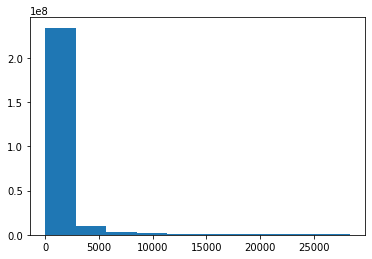

In [16]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=data.sleep_time_modified.quantile(q=0.99)])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

Again we see that most of the observations have a very low sleep time so we again constrict the interval of intrest. 

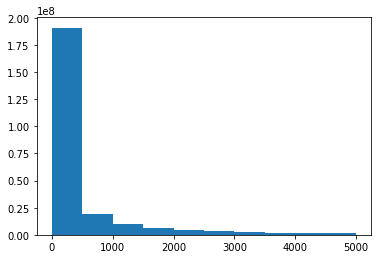

In [17]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=5000])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

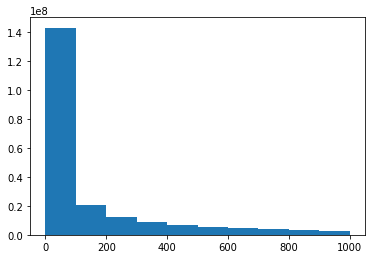

In [18]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=1000])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

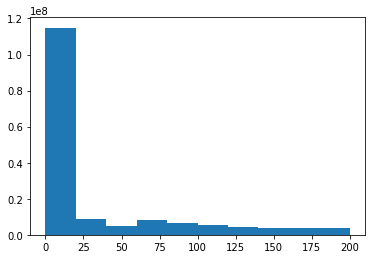

In [19]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=200])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

# Opening the same data twice
Here we investigate the possiblity of opening the same data right after each other. As we are intrested in the patterns of usage it is not neccessarily of much intrest that you close an app and immediatly open it again to continue the same activity.

We start by the number of times the app which is opend is the same as the last one opened.

In [12]:
data["previous_app_code"]=user_groups.app_code.shift(1)

In [21]:
data.app_code[data.app_code==data.previous_app_code].count()

55448447

In [22]:
data.app_code[data.app_code==data.previous_app_code].count()/data.shape[0]*100

21.791454132467504

we now take all look at the sleeping times for these obervations

In [23]:
print("max sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].max())
print("min sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].min())

max sleep time:  6067204.0
min sleep time:  -23445.0


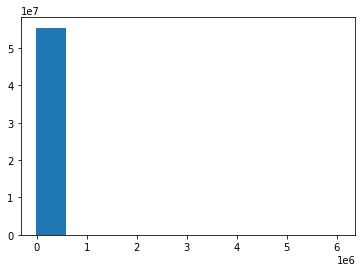

In [24]:
plt.hist(data.sleep_time[data.app_code==data.previous_app_code])
plt.show()

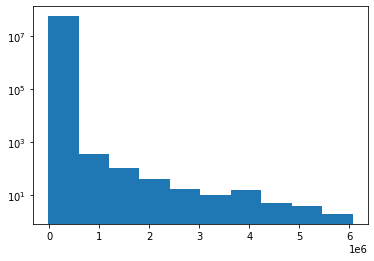

In [36]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code) ])#& (data.sleep_time<1000000)])
plt.yscale('log')
plt.show()

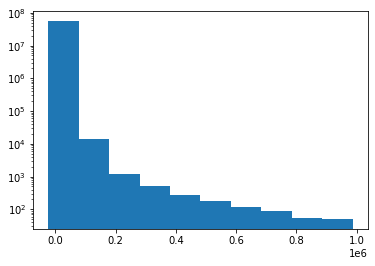

In [37]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<1000000)])
plt.yscale('log')
plt.show()

However we are esspecially interested in the ones used very close to each other.

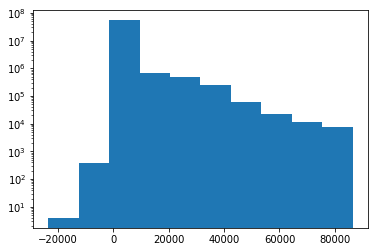

In [41]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)])
plt.yscale('log')
plt.show()

In [44]:
print("number of times the same app is opened while the app is in use: ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<0)].count())
print("number of times the same app is opened right after (sleep time 0): ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time==0)].count())

number of times the same app is opened while the app is in use:  4821
number of times the same app is opened right after (sleep time 0):  409933


We see that a small number is used at the same time. For our purpesis it is clear that these should be combined. Also we see that approcimately 400000 are opened imediatly after with no sleep time in between. For these it is also clear that they can be combined.

Since we now filter out the apps which overlap in use time.

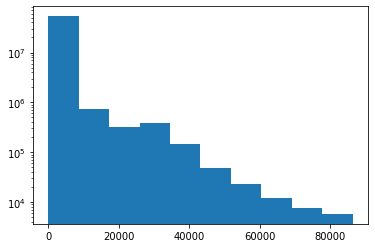

In [46]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)&(data.sleep_time>0)])
plt.yscale('log')
plt.show()

In [57]:
data.sleep_time[(data.app_code==data.previous_app_code)].mean()

1553.9468436329696

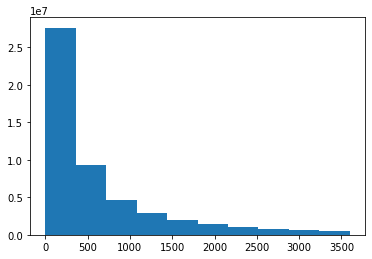

In [49]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60)&(data.sleep_time>0)])
plt.show()

In [52]:
500/60

8.333333333333334

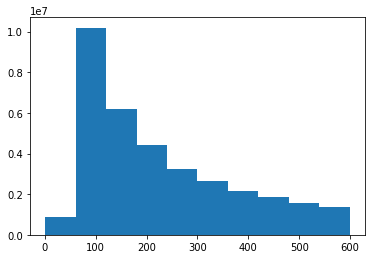

In [55]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<10*60)&(data.sleep_time>0)])
plt.show()

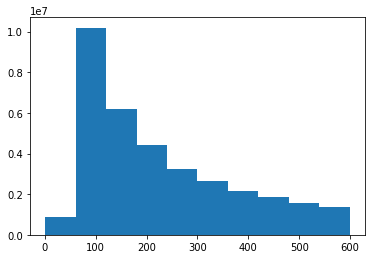

In [56]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<10*60)&(data.sleep_time>0)])
plt.show()

In [64]:
data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)].count()/data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)].count()

0.6278039527530889

Now we combine the observations where the same app is used again after a maximum of 10min sleep time.

In [65]:
data[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0
26,com.android.chrome,0,33229,33239,10,7649,460.0,460.0,7649.0
28,com.sonyericsson.album,0,33552,33562,10,45260,217.0,217.0,45260.0
46,com.sonyericsson.android.socialphonebook,0,48785,48795,10,45261,491.0,491.0,45261.0
...,...,...,...,...,...,...,...,...,...
254450388,com.whatsapp,9999,29163246,29163262,16,53003,217.0,217.0,53003.0
254450389,com.whatsapp,9999,29163490,29163500,10,53003,228.0,228.0,53003.0
254450399,com.facebook.katana,9999,29167795,29167859,64,19968,280.0,280.0,19968.0
254450405,com.snapchat.android,9999,29201485,29201495,10,44880,256.0,256.0,44880.0


In [36]:
data2=data.copy()#[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)]

In [26]:
list(data2[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)].index-1)

[6,
 13,
 25,
 27,
 45,
 61,
 70,
 74,
 79,
 94,
 96,
 103,
 111,
 116,
 120,
 133,
 159,
 172,
 173,
 176,
 180,
 181,
 191,
 196,
 204,
 224,
 234,
 238,
 239,
 245,
 264,
 269,
 286,
 288,
 314,
 326,
 327,
 330,
 340,
 341,
 344,
 351,
 356,
 374,
 399,
 405,
 409,
 416,
 417,
 418,
 419,
 433,
 466,
 467,
 479,
 494,
 502,
 503,
 504,
 508,
 529,
 534,
 555,
 556,
 558,
 586,
 595,
 596,
 605,
 617,
 628,
 629,
 649,
 653,
 671,
 672,
 673,
 674,
 675,
 691,
 703,
 708,
 709,
 741,
 743,
 746,
 760,
 779,
 784,
 788,
 789,
 798,
 799,
 800,
 801,
 814,
 848,
 849,
 853,
 879,
 884,
 898,
 926,
 929,
 931,
 932,
 936,
 952,
 956,
 966,
 1008,
 1010,
 1018,
 1066,
 1067,
 1068,
 1084,
 1089,
 1098,
 1144,
 1168,
 1182,
 1186,
 1193,
 1201,
 1205,
 1206,
 1217,
 1228,
 1229,
 1237,
 1242,
 1277,
 1282,
 1289,
 1291,
 1292,
 1300,
 1315,
 1317,
 1320,
 1322,
 1365,
 1370,
 1373,
 1379,
 1380,
 1391,
 1395,
 1396,
 1412,
 1417,
 1418,
 1419,
 1420,
 1427,
 1429,
 1430,
 1434,
 1439,
 1

In [37]:
data2.loc[list(data2[(data2.app_code==data2.previous_app_code)& (data2.sleep_time<=10*60)&(data2.sleep_time>0)].index-1),"end_time"]=data2.loc[list(data2[(data2.app_code==data2.previous_app_code)& (data2.sleep_time<=10*60)&(data2.sleep_time>0)].index),"end_time"].to_list()

In [35]:
data.loc[list(data[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)].index),"end_time"].to_list()

[2221,
 4742,
 33239,
 33562,
 48795,
 59713,
 88663,
 90893,
 117386,
 134859,
 135703,
 160091,
 174226,
 175254,
 176166,
 177567,
 238519,
 245456,
 245625,
 251048,
 255249,
 255420,
 263322,
 266491,
 291289,
 297423,
 301175,
 303542,
 303961,
 309263,
 325958,
 334618,
 368594,
 369485,
 427974,
 465096,
 465476,
 466456,
 480948,
 481154,
 487655,
 501198,
 503564,
 513311,
 561193,
 588359,
 588848,
 596741,
 596912,
 597373,
 597654,
 632994,
 733650,
 734511,
 751633,
 770294,
 772247,
 772781,
 773259,
 773990,
 842129,
 852304,
 886839,
 887127,
 888115,
 908293,
 929693,
 930061,
 934998,
 942639,
 945111,
 945341,
 990354,
 991832,
 1009421,
 1009780,
 1010261,
 1010445,
 1010589,
 1027503,
 1070151,
 1077726,
 1077899,
 1112676,
 1115649,
 1117421,
 1121979,
 1169208,
 1171606,
 1172787,
 1172887,
 1182221,
 1182524,
 1182618,
 1183211,
 1201914,
 1286630,
 1287317,
 1290521,
 1328477,
 1337344,
 1344183,
 1423587,
 1424207,
 1424746,
 1424887,
 1425610,
 1449200,
 145

In [41]:
data2.iloc[170:175,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
170,com.facebook.katana,0,244169,244579,410,19968,2818.0,2818.0,27441.0
171,com.android.chrome,0,244579,244699,120,7649,0.0,0.0,19968.0
172,com.facebook.katana,0,244980,245456,117,19968,281.0,281.0,7649.0
173,com.facebook.katana,0,245230,245625,226,19968,133.0,133.0,19968.0
174,com.facebook.katana,0,245529,245625,96,19968,73.0,73.0,19968.0


In [42]:
data.iloc[170:176,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
170,com.facebook.katana,0,244169,244579,410,19968,2818.0,2818.0,27441.0
171,com.android.chrome,0,244579,244699,120,7649,0.0,0.0,19968.0
172,com.facebook.katana,0,244980,245097,117,19968,281.0,281.0,7649.0
173,com.facebook.katana,0,245230,245456,226,19968,133.0,133.0,19968.0
174,com.facebook.katana,0,245529,245625,96,19968,73.0,73.0,19968.0
175,com.facebook.katana,0,250815,250825,10,19968,5190.0,5190.0,19968.0


In [46]:
data2=data.copy()

In [59]:
data2['new event']=data2.groupby(['user_id',"app_code"]).sleep_time.apply(lambda s: s>60*60*10)

In [60]:
data2[data2['new event']==False]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new event
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN,False
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0,False
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0,False
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0,False
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0,False
...,...,...,...,...,...,...,...,...,...,...
254450417,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,185.0,185.0,19968.0,False
254450418,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0,False
254450419,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0,False
254450420,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,5890.0,5890.0,23875.0,False


In [63]:
data2['event'] = data2.groupby(['user_id',"app_code"])['new event'].cumsum().astype('int')

In [64]:
data2

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new event,event
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN,False,0
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0,False,0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0,False,0
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0,False,0
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...
254450417,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,185.0,185.0,19968.0,False,19
254450418,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0,False,3
254450419,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0,False,0
254450420,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,5890.0,5890.0,23875.0,False,7


In [71]:
data2.groupby(['user_id',"app_code", 'event'])['start_time'].min().to_list()

[8013944,
 597694,
 3689,
 14032441,
 14116963,
 14721112,
 16618566,
 88663,
 46384,
 11779062,
 12901478,
 4794149,
 588529,
 441,
 10011208,
 10657920,
 11002098,
 16530444,
 18608198,
 1091857,
 19520172,
 48159,
 746895,
 7499247,
 8329074,
 8664205,
 16132701,
 5782382,
 8013773,
 693074,
 5040221,
 773509,
 0,
 553773,
 811606,
 1418069,
 2968957,
 4610589,
 5475381,
 5562442,
 6088407,
 6848165,
 7579477,
 8489525,
 12136586,
 12471578,
 13344642,
 13420216,
 13597254,
 13859390,
 13939400,
 14200148,
 14288768,
 14371341,
 14469255,
 14632626,
 14896202,
 14981493,
 17576277,
 17833498,
 18875071,
 19900494,
 19999883,
 20086989,
 121572,
 6214535,
 5782863,
 5783143,
 5408907,
 4217873,
 121582,
 1012,
 16877568,
 28766,
 12853197,
 1673229,
 1717254,
 67574,
 1582,
 10829995,
 11435111,
 12822782,
 2732427,
 634171,
 4184172,
 4535886,
 49606,
 7249920,
 16717061,
 16962869,
 3318938,
 6292008,
 11997249,
 12226598,
 2232270,
 17500617,
 1077899,
 144069,
 15047143,
 1516296

In [101]:
res=data2.groupby(['user_id',"app_code", 'event'],as_index=False)['end_time'].agg(['last'])

In [102]:
res.columns = list(map(''.join, res.columns.values))

In [110]:
data2.apply(lambda l: (l.user_id,l.app_code,l.event) in res.index.to_list(),axis=1)

KeyboardInterrupt: 

In [112]:
(data2.user_id.values,data2.app_code.values)

(array([   0,    0,    0, ..., 9999, 9999, 9999]),
 array([19968,  7649, 23916, ..., 23875, 33357, 23949]))

In [107]:
data2[(data2.user_id,data2.app_code,data2.event) in res.index.to_list()]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [106]:
[a_tuple[0] for a_tuple in res.index.to_list()]


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
